In [32]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [33]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.x = np.array(self.data.iloc[:, :-1])
        self.y = np.array(self.data.iloc[:, -1])
        
    def __getitem__(self, index):
        return torch.tensor(self.x[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.long)
        
    def __len__(self):
        return len(self.data)



In [34]:
train_dataset = MyDataset('cure_the_princess_train.csv')
val_dataset = MyDataset('cure_the_princess_validation.csv')
test_dataset = MyDataset('cure_the_princess_test.csv')


In [35]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
# MLP Modelimizi overfit etmek için güncelleyelim
class MLP_overfit(nn.Module):
    def __init__(self):
        super(MLP_overfit, self).__init__()
        self.fc1 = nn.Linear(13, 256)  # daha fazla nöron eklendi
        self.fc2 = nn.Linear(256, 128)  # daha fazla nöron eklendi
        self.fc3 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

    
# Yeni overfit modelimizi oluşturalım
model_overfit = MLP_overfit()


In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_overfit.parameters(), lr=0.01)

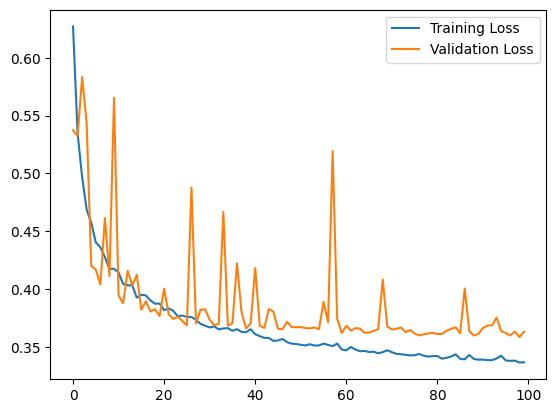

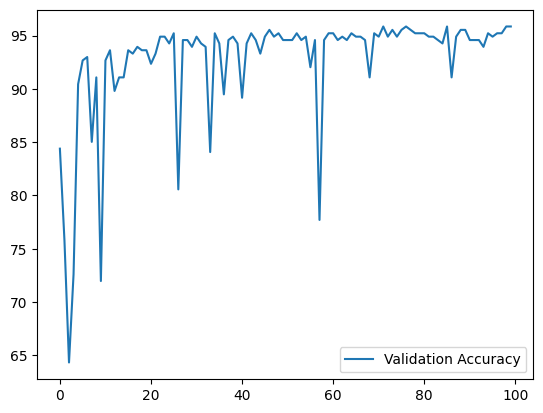

In [38]:

# Yeni eğitim fonksiyonumuzu tanımlayalım
def train_overfit(model, train_dataloader, optimizer, loss_fn):
    model.train()
    train_loss_list = []
    for batch, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
    return np.mean(train_loss_list)

# Yeni doğrulama fonksiyonumuzu tanımlayalım
def evaluate_overfit(model, val_dataloader, loss_fn):
    model.eval()
    val_loss_list = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_dataloader:
            output = model(data)
            loss = loss_fn(output, target)
            val_loss_list.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    val_loss = np.mean(val_loss_list)
    val_acc = 100 * correct / total
    return val_loss, val_acc

# Overfit için eğitim ve doğrulama adımlarını gerçekleştirelim
train_loss_list = []
val_loss_list = []
val_acc_list = []
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = train_overfit(model_overfit, train_dataloader, optimizer, loss_fn)
    val_loss, val_acc = evaluate_overfit(model_overfit, val_dataloader, loss_fn)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
   # print('Epoch: [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.2f}%'.format(epoch+1, num_epochs, train_loss, val_loss, val_acc))

# Overfit için eğitim ve doğrulama loss'larını gösteren grafikleri çizdirelim
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.show()

# Overfit için doğruluk değerlerini gösteren grafikleri çizdirelim
plt.plot(val_acc_list, label='Validation Accuracy')
plt.legend()
plt.show()